# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
rel_path = '../Data/MRA_Mission_Data_Archive_Public_View_for_Open_Data_2013-2020.csv'
df = pd.read_csv(rel_path)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_37774/1563785593.py:2: DtypeWarning: Columns (48,49,54,55,57,60,61,68,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(rel_path)


# Initial Data Cleanup
- lower_snake_case columns
- drop features that are not indicators of `time` target
    - `incident_number`
    - `objectid`
    - `globalid`
    - `team_not_listed`
    - `number_team_listed`
    - `number_tm_injured`
    - `level_of_care_rescuer`
    - `medical_problems_team_member`
    - `medical_problems_other_team_member`
    - `creationdate`
    - `creator`
    - `editdate`
    - `editor`
    - `incident_uuid`
    - `form_version`

**Renaming columns with lower snake case**

In [3]:
df.rename(columns={col: col.lower() for col in df.columns}, inplace=True)

#### Dropping features listed above

In [4]:
df.drop(['incident_number', 'objectid', 'globalid', 'team_not_listed', 'number_tm_injured', 
         'level_of_care_rescuer', 'medical_problems_team_member', 'medical_problems_other_team_mem', 
         'creationdate', 'creator', 'editdate', 'editor', 'incident_uuid', 'form_version'
        ], axis=1, inplace=True)

In [5]:
print(df.shape)
df.head()

(16574, 70)


,x,y,team,region,home_county,mutual_aid,mutual_aid_number,lead_agency,type,training_type,...,number_sub_ill_injured,number_sub_doa,number_sub_not_found,number_found_locations,point_found_count,level_of_care_subject,medical_problems_subject,medical_problems_other_subject,medical_provider,medical_provider_other
0,-79.85480,40.36169,Allegheny_Mtn_Rescue_Group,Appalachian Region,Allegheny County - Pennsylvania,NO,NaN,NaN,SEARCH,NaN,...,0.0,0.0,0.0,1.0,1,NaN,NaN,NaN,NaN,NaN
1,-80.43129,41.11171,Allegheny_Mtn_Rescue_Group,Appalachian Region,Allegheny County - Pennsylvania,YES,NaN,NO,SEARCH,NaN,...,0.0,1.0,0.0,1.0,1,NaN,NaN,NaN,NaN,NaN
2,-111.39365,33.52634,Central_Arizona_MRA,Desert Region,Maricopa County - Arizona,NO,NaN,NaN,RECOVERY,NaN,...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-111.56268,33.51890,Central_Arizona_MRA,Desert Region,Maricopa County - Arizona,NO,NaN,NaN,RESCUE,NaN,...,1.0,0.0,0.0,NaN,NaN,BLS,Trauma_Extremities,NaN,"SAR_team,Local_EMS",NaN
4,-79.72418,39.90210,Allegheny_Mtn_Rescue_Group,Appalachian Region,Allegheny County - Pennsylvania,YES,NaN,NO,SEARCH,NaN,...,0.0,0.0,0.0,1.0,1,NaN,NaN,NaN,NaN,NaN


# Data Cleaning
- The dataset includes datapoints that are not "typical" Search and Rescue missions. Through data analysis, I will drop datapoints that do not describe incidents where a live victim was rescued. 

### Creating 2 functions to track rows dropped
- 1st function will print a statement describing the process of dropping rows and will store all drops into a dictionary to view after all data cleaning completed.
- 2nd function will return dataframe of all dropping actions performed.

In [6]:
uncleaned_total = df.shape[0]
total_rows_dropped = 0
rows_dropped_dict = {}

def drop_rows(desc, mask):
    
    rows_dropped = mask.shape[0]
    global total_rows_dropped
    total_rows_dropped += rows_dropped
    perc_data = round(rows_dropped/uncleaned_total*100, 1)
        
    df.drop(index=mask.index, inplace=True)
    df.reset_index(drop=True, inplace=True)

    rows_dropped_dict[desc] = [rows_dropped, perc_data, df.shape[0]]

    print('\033[1m' + desc + '\033[0m')
    print('Number Rows Dropped:', rows_dropped, 
          '-', perc_data, '%')
    print('Total Rows Dropped: ', total_rows_dropped, 
          '-', round(total_rows_dropped/uncleaned_total*100, 1), '%')
    print('Original Total Rows:', uncleaned_total)
    print('Current Total Rows: ', df.shape[0], '\n')
    
def rows_dropped():
    rows_dropped = pd.DataFrame(data={'num_dropped':0, 
                                      'perc_data':0,
                                      'total_rows':uncleaned_total},
                                index=['Original Dataset'])

    for key, val in rows_dropped_dict.items():
        rows_dropped.loc[key] = [val[0], val[1], val[2]]
        
    rows_dropped.loc['Total'] = rows_dropped.sum(axis=0)
    rows_dropped.loc['Total']['total_rows'] = df.shape[0]
    
    return rows_dropped

# Type, Category, Category Other
- While analyzing this feature, it becomes apparent that this dataset include many datapoints that are not real SAR missions where a live, human victim is in need of rescuing 
    - e.g. training, public event display, evidence search, suicides, animal rescue
    
- I am subsetting the dataset to only include true ***typical*** SAR missions in order to predict the time it takes to rescue a live victim(s).

#### Cleaning strings in `type`, `category`, `category_other` 
- Lowercasing all strings
- Replacing emptty strings with np.nan

In [7]:
for col in ['type', 'category', 'category_other']:
    df[col] = [x.lower()if isinstance(x, str) else x for x in df[col]]
    df[col].replace(' ', np.nan, inplace=True)

## Type
- This feature describes the mission type for each datapoint.

#### Cleaning `type` to remove special characters

In [8]:
df['type'] = [x.replace('_', ' ').replace('-', ' ').replace('–', ' ') 
              if isinstance(x, str) 
              else x 
              for x in df.type]

**Dropping datapoints that aren't actual and typical SAR missions**

In [9]:
type_mask = df[(df.type == 'abduction') |
               (df.type == 'animal rescue') |
               (df.type == 'assist/turnaround') |
               (df.type == 'call out only') |
               (df.type == 'evidence search') |
               (df.type == 'recovery') | 
               (df.type == 'standby') |
               (df.type == 'training') |
               (df.type == 'turnaround') | 
               (df.type == 'public relations/psar event')]

drop_rows('"type" that aren\'t true SAR missions', 
          type_mask)

"type" that aren't true SAR missions
Number Rows Dropped: 1608 - 9.7 %
Total Rows Dropped:  1608 - 9.7 %
Original Total Rows: 16574
Current Total Rows:  14966 



## Training Type
- After dropping rows above, this feature is completely Null, so it's being dropped

In [10]:
df.drop('training_type', axis=1, inplace=True)

## Category
- Like `type`, this feature describes the category of event resulting in the SAR mission
- Datapoints that are not true SAR missions will be dropped

In [11]:
cat_mask = df[(df.category == 'abduction') |
              (df.category == 'animal') |
              (df.category == 'despondent suicide') | 
              (df.category == 'despondent/suicide') |               
              (df.category == 'homicide') | 
              (df.category == 'runaway') | 
              (df.category == 'school/education program') | 
              (df.category == 'training')
             ]

drop_rows('"category" that aren\'t true SAR missions', 
           cat_mask)

"category" that aren't true SAR missions
Number Rows Dropped: 553 - 3.3 %
Total Rows Dropped:  2161 - 13.0 %
Original Total Rows: 16574
Current Total Rows:  14413 



## Category Other
- This feature describes in more detail the category of event
- Datapoints where `category_other` are not true SAR missions will be dropped

In [12]:
cat_other_mask = df[(df.category_other =='abducted' ) |
                    (df.category_other =='abduction' ) |
                    (df.category_other =='body dump' ) |
                    (df.category_other =='burglar' ) |
                    (df.category_other =='car crash, possible dui related' ) |
                    (df.category_other =='cold case missing person' ) |
                    (df.category_other =='crime / warrant' ) |
                    (df.category_other =='crime suspect' ) |
                    (df.category_other =='criminal' ) |
                    (df.category_other =='despondent suicide' ) |
                    (df.category_other =='dog' ) |
                    (df.category_other =='dog rescue' ) |
                    (df.category_other =='dogs' ) |
                    (df.category_other =='drug dealer' ) |
                    (df.category_other =='dui' ) |
                    (df.category_other =='escaped prisoner' ) |
                    (df.category_other =='escaped prisoner from fremont east complex' ) |
                    (df.category_other =='escaped trustee' ) |
                    (df.category_other =='fema k-9' ) |
                    (df.category_other =='hiding from cartel' ) |
                    (df.category_other =='human remains search for possible homicide victim.' ) |
                    (df.category_other =='immobile and unresponsive' ) |
                    (df.category_other =='intoxicated walk-away' ) |
                    (df.category_other =='jail escapee' ) |
                    (df.category_other =='k9' ) |
                    (df.category_other =='kidnapping/murder' ) |
                    (df.category_other =='law enforcement subject' ) |
                    (df.category_other =='law enforecement search for a possible hrd' ) |
                    (df.category_other =='mine exploration - dog recovery' ) |
                    (df.category_other =='missing male from wellness check by fpd' ) |
                    (df.category_other =='missing rave attendee' ) |
                    (df.category_other =='party goer' ) |
                    (df.category_other =='possible crime victim' ) |
                    (df.category_other =='possible suicide' ) |
                    (df.category_other =='possible victim of crime' ) |
                    (df.category_other =='possibly lost, possibly drug related ' ) |
                    (df.category_other =='reported missing by boyfriend' ) |
                    (df.category_other =='searching for lost pet' ) |
                    (df.category_other =='subject walked away from vehhicle accident, roll over' ) |
                    (df.category_other =='subject walked out, thought to be hiking but found in local motel.' ) |
                    (df.category_other =="subject's car located near road.  may have been lost." ) |
                    (df.category_other =='suspect' ) |
                    (df.category_other =='suspect search' ) |
                    (df.category_other =='transient' ) |
                    (df.category_other =='unk. skull found.' ) |
                    (df.category_other =='unknown walk-away' ) |
                    (df.category_other =='unsure at time of search. turned into a murder subject search.') |
                    (df.category_other =='a guy kicked out of a bar.') |
                    (df.category_other =='abandoned vehicle') |
                    (df.category_other =='evidence search') |
                    (df.category_other =='homicide') |
                    (df.category_other =='homicide victim') |
                    (df.category_other =='homless ') |
                    (df.category_other =='left home.') |
                    (df.category_other =='mva patient / suspect') |
                    (df.category_other =='missing party, car towed, possible despondant/suicide') |
                    (df.category_other =='ptsd')]

drop_rows('"category_other" that aren\'t true SAR missions', 
           cat_other_mask)

"category_other" that aren't true SAR missions
Number Rows Dropped: 113 - 0.7 %
Total Rows Dropped:  2274 - 13.7 %
Original Total Rows: 16574
Current Total Rows:  14300 



---
---

# Total Hours - Target
#### Cleaning Total Hours
- replace all values <= 0 with np.nan
- dropping all Nulls

In [13]:
df['total_hours'] = [np.nan if time <=0 else time for time in df.total_hours]

drop_rows('"total_hours" are Null', 
          df[pd.isna(df.total_hours)])

drop_rows('"total_hours" > 168 (7 days)', 
          df[df.total_hours >= 168])

"total_hours" are Null
Number Rows Dropped: 678 - 4.1 %
Total Rows Dropped:  2952 - 17.8 %
Original Total Rows: 16574
Current Total Rows:  13622 

"total_hours" > 168 (7 days)
Number Rows Dropped: 659 - 4.0 %
Total Rows Dropped:  3611 - 21.8 %
Original Total Rows: 16574
Current Total Rows:  12963 



# Date

### Creating `year` by parsing `date`
- Replacing 1 incorrect entry
- Dropping datapoints that predate 2014 as the dataset goes back to 1970's, but these dates are all outliers 

In [14]:
df['year'] = [int(x[:4]) for x in df.date]

df.year.replace(2104, 2014, inplace=True)

drop_rows('"date" <= 2014', df[df.year <= 2013])

"date" <= 2014
Number Rows Dropped: 46 - 0.3 %
Total Rows Dropped:  3657 - 22.1 %
Original Total Rows: 16574
Current Total Rows:  12917 



---
---

# Metadata for all 5 Subjects
- This dadtaset includes metadata for up to 5 subjects. The is also a feature `number_subjects` that can exceed the 5 included subjects. This `number_subjects` will be corrected and imputed based on these metadata

## Cleaning values for all subject metadata
- replacing ages <= 0 with np.nan
- lowercasing all object variables, replacing empty strings with np.nan, correcting miscellaneous inconsistencies. 

In [15]:
for i in list(range(1, 6)):
    age = 'age_sub_'
    df[age+str(i)] = [np.nan if age <=0 
                      else age 
                      for age in df[age+str(i)]]
    
subs_meta = ['gender', 'fitness', 'experience', 'mental_factor', 'mental_rating']

for col in subs_meta:    
    for i in list(range(1, 6)):
        col_name = col+'_sub_'+str(i)

        df[col_name] = [x.lower()if isinstance(x, str) 
                        else x for x in df[col_name]]
        df[col_name].replace(' ', np.nan, inplace=True)
        df[col_name].replace('unknown', np.nan, inplace=True)
        df[col_name].replace('m', 'male', inplace=True)

## Creating functions to return dataframes of metadata value_counts 

In [16]:
df.mental_rating_sub_1.isna().sum()

10569

In [17]:
def feat_df(feat):

    cats = {}

    if feat == 'age':
        cats = {'non_null':[], 'nan':[]}
        for i in list(range(1, 6)):
            for key, val in cats.items():
                if key == 'nan':
                    cats[key].append(df[pd.isna(df[feat + '_sub_' + str(i)])].shape[0])
                else:
                    cats[key].append(df[pd.notnull(df[feat + '_sub_' + str(i)])].shape[0])
        
    else:
        for key in df[feat+'_sub_1'].unique():
            if str(key) == 'nan':
                cats[str(key)] = []
            else:
                cats[key] = []

        for i in list(range(1, 6)):
            for key, val in cats.items():
                if key == 'nan':
                    cats[key].append(df[pd.isna(df[feat + '_sub_' + str(i)])].shape[0])
                else:
                    cats[key].append(df[df[feat + '_sub_' + str(i)] == key].shape[0])           

    feat_df = pd.DataFrame(data=cats,
                          index=[feat + '_sub_' + str(i) 
                                 for i in list(range(1, 6))])
    
    nan = feat_df.nan
    feat_df.drop('nan', axis=1, inplace=True)
    feat_df['NaN'] = nan

    feat_df.loc['dataset_totals']= feat_df.sum(axis=0)
    feat_df.loc['dataset_totals']['NaN'] = df.shape[0] - \
                                               int(feat_df.iloc[-1:, :-1].sum(axis=1).values)
                
    return feat_df

In [18]:
def feat_df(feat):

    unique_dict = {}

    for key in df[feat+'_sub_1'].unique():
        if str(key) == 'nan':
            unique_dict[key] = df.mental_rating_sub_1.isna().sum()
        else:
            unique_dict[key] = df[df.mental_rating_sub_1 == key].shape[0]

    return unique_dict
    
feat_df('mental_rating')

{'mild': 112, 'moderate': 160, nan: 10569, 'normal': 2023, 'severe': 53}

## Ages

In [19]:
def fitness():
    cats = {'poor':[], 'fair':[], 'good':[], 'excellent':[], 'NaN':[]}
    fitness = 'fitness_sub_'

    for i in list(range(1, 6)):
        for key, val in cats.items():
            if key == 'NaN':
                cats[key].append(df[pd.isna(df[fitness+str(i)])].shape[0])
            else:
                cats[key].append(df[df[fitness+str(i)] == key].shape[0])

    fitness = pd.DataFrame(data=cats,
                          index=['fitness_sub_'+str(i) 
                                 for i in list(range(1, 6))])
    fitness.loc['dataset_totals']= fitness.sum(axis=0)
    fitness.loc['dataset_totals']['NaN'] = df.shape[0] - \
                                               int(fitness.iloc[-1:, :-1].sum(axis=1).values)
    return fitness 

In [20]:
def ages():
    cats = {'non_null':[], 'NaN':[]}
    ages = 'age_sub_'
    
    for i in list(range(1, 6)):
        for key, val in cats.items():
            if key == 'NaN':
                cats[key].append(df[pd.isna(df[ages+str(i)])].shape[0])
            else:
                cats[key].append(df[pd.notnull(df[ages+str(i)])].shape[0])

    ages = pd.DataFrame(data=cats, 
                        index=['age_sub_'+str(i) 
                               for i in list(range(1, 6))])
    
    ages.loc['dataset_totals'] = ages.sum(axis=0)

    ages.loc['dataset_totals']['NaN'] = df.shape[0] - \
                                               int(ages.iloc[-1:, :-1].sum(axis=1).values)
    return ages

In [21]:
feat_df('age')

{79.0: 0,
 55.0: 0,
 nan: 10569,
 43.0: 0,
 21.0: 0,
 50.0: 0,
 26.0: 0,
 22.0: 0,
 49.0: 0,
 76.0: 0,
 24.0: 0,
 17.0: 0,
 34.0: 0,
 71.0: 0,
 19.0: 0,
 65.0: 0,
 20.0: 0,
 40.0: 0,
 70.0: 0,
 45.0: 0,
 68.0: 0,
 61.0: 0,
 64.0: 0,
 33.0: 0,
 9.0: 0,
 88.0: 0,
 30.0: 0,
 80.0: 0,
 32.0: 0,
 15.0: 0,
 53.0: 0,
 66.0: 0,
 23.0: 0,
 67.0: 0,
 28.0: 0,
 72.0: 0,
 58.0: 0,
 63.0: 0,
 36.0: 0,
 16.0: 0,
 74.0: 0,
 77.0: 0,
 75.0: 0,
 35.0: 0,
 29.0: 0,
 54.0: 0,
 44.0: 0,
 52.0: 0,
 78.0: 0,
 12.0: 0,
 13.0: 0,
 18.0: 0,
 41.0: 0,
 14.0: 0,
 25.0: 0,
 6.0: 0,
 11.0: 0,
 48.0: 0,
 57.0: 0,
 46.0: 0,
 31.0: 0,
 62.0: 0,
 85.0: 0,
 37.0: 0,
 38.0: 0,
 83.0: 0,
 73.0: 0,
 56.0: 0,
 60.0: 0,
 10.0: 0,
 8.0: 0,
 27.0: 0,
 1.0: 0,
 5.0: 0,
 2.0: 0,
 47.0: 0,
 51.0: 0,
 39.0: 0,
 3.0: 0,
 59.0: 0,
 82.0: 0,
 84.0: 0,
 42.0: 0,
 69.0: 0,
 86.0: 0,
 7.0: 0,
 81.0: 0,
 89.0: 0,
 90.0: 0,
 91.0: 0,
 87.0: 0,
 92.0: 0,
 4.0: 0,
 2014.0: 0,
 2011.0: 0,
 198.0: 0,
 2018.0: 0,
 115.0: 0}

In [22]:
df.age_sub_1.value_counts().sort_index().tail(6)

92.0      3
115.0     1
198.0     1
2011.0    1
2014.0    1
2018.0    1
Name: age_sub_1, dtype: int64

In [23]:
drop_rows('"age_sub_1" > 92', 
          df[df.age_sub_1 > 92])

"age_sub_1" > 92
Number Rows Dropped: 5 - 0.0 %
Total Rows Dropped:  3662 - 22.1 %
Original Total Rows: 16574
Current Total Rows:  12912 



## Genders

In [24]:
feat_df('gender')

{'male': 0, 'female': 0, nan: 10564}

## Fitness

In [25]:
feat_df('fitness')

{nan: 10564, 'good': 0, 'fair': 0, 'excellent': 0, 'poor': 0}

In [26]:
def gender():    
    female, male, gender_NaN = [], [], []
    gender = 'gender_sub_'
    
    for i in list(range(1, 6)):
        female.append(df[df[gender+str(i)] == 'female'].shape[0])
        male.append(df[df[gender+str(i)] == 'male'].shape[0])
        gender_NaN.append(df[pd.isna(df[gender+str(i)])].shape[0])
    
    gender = pd.DataFrame(data={'female':female, 
                                'male':male,  
                                'NaN':gender_NaN}, 
                          index=['gender_sub_'+str(i) 
                                 for i in list(range(1, 6))])    
    gender.loc['dataset_totals']= gender.sum(axis=0)    
    gender.loc['dataset_totals']['NaN'] = df.shape[0] - \
                                           int(gender.iloc[-1:, :-1].sum(axis=1).values)        
    return gender 

In [27]:
def fitness():
    cats = {'poor':[], 'fair':[], 'good':[], 'excellent':[], 'NaN':[]}
    fitness = 'fitness_sub_'

    for i in list(range(1, 6)):
        for key, val in cats.items():
            if key == 'NaN':
                cats[key].append(df[pd.isna(df[fitness+str(i)])].shape[0])
            else:
                cats[key].append(df[df[fitness+str(i)] == key].shape[0])

    fitness = pd.DataFrame(data=cats,
                          index=['fitness_sub_'+str(i) 
                                 for i in list(range(1, 6))])
    fitness.loc['dataset_totals']= fitness.sum(axis=0)
    fitness.loc['dataset_totals']['NaN'] = df.shape[0] - \
                                               int(fitness.iloc[-1:, :-1].sum(axis=1).values)
    return fitness 

In [28]:
def experience():
    cats = {'poor':[], 'fair':[], 'good':[], 'excellent':[], 'NaN':[]}
    experience = 'experience_sub_'

    for i in list(range(1, 6)):
        for key, val in cats.items():
            if key == 'NaN':
                cats[key].append(df[pd.isna(df[experience+str(i)])].shape[0])
            else:
                cats[key].append(df[df[experience+str(i)] == key].shape[0])

    experience = pd.DataFrame(data=cats,
                          index=['experience_sub_'+str(i) 
                                 for i in list(range(1, 6))])
    experience.loc['dataset_totals']= experience.sum(axis=0)
    experience.loc['dataset_totals']['NaN'] = df.shape[0] - \
                                               int(experience.iloc[-1:, :-1].sum(axis=1).values)
    return experience

In [29]:
def mental_factor():
    cats = {'non_null':[], 'none':[], 'NaN':[]}
    mental = 'mental_factor_sub_'
    
    for i in list(range(1, 6)):
        for key, val in cats.items():
            if key == 'NaN':
                cats[key].append(df[pd.isna(df[mental+str(i)])].shape[0])
            elif key == 'none':
                cats[key].append(df[df[mental+str(i)] == 'none'].shape[0])            
            else:
                cats[key].append(df[pd.notnull(df[mental+str(i)])].shape[0])

    mental = pd.DataFrame(data=cats, 
                        index=['mental_factor_sub_'+str(i) 
                               for i in list(range(1, 6))])    
    mental.loc['dataset_totals'] = mental.sum(axis=0)
    mental.loc['dataset_totals']['NaN'] = df.shape[0] - \
                                               int(mental.iloc[-1:, :-1].sum(axis=1).values)
    return mental

In [30]:
def mental_rating():
    cats = {'normal':[], 'moderate':[], 'mild':[], 'severe':[], 'NaN':[]}
    mental = 'mental_rating_sub_'
    
    for i in list(range(1, 6)):
        for key, val in cats.items():
            if key == 'NaN':
                cats[key].append(df[pd.isna(df[mental+str(i)])].shape[0])
            else:
                cats[key].append(df[pd.notnull(df[mental+str(i)])].shape[0])

    mental = pd.DataFrame(data=cats, 
                        index=['mental_rating_sub_'+str(i) 
                               for i in list(range(1, 6))])    
    mental.loc['dataset_totals'] = mental.sum(axis=0)
    mental.loc['dataset_totals']['NaN'] = df.shape[0] - \
                                               int(mental.iloc[-1:, :-1].sum(axis=1).values)
    return mental

## Experiences

In [31]:
feat_df('experience')

{nan: 10564, 'good': 0, 'fair': 0, 'poor': 0, 'excellent': 0}

## Mental Factors

In [32]:
mental_factor()

,non_null,none,NaN
mental_factor_sub_1,2810,2316,10102
mental_factor_sub_2,217,213,12695
mental_factor_sub_3,50,50,12862
mental_factor_sub_4,16,16,12896
mental_factor_sub_5,5,5,12907
dataset_totals,3098,2600,7214


### Mental Factor Sub 1

#### Consolidating `mental_factor_sub_1` categories

In [33]:
df['mental_factor_sub_1'] = [x.replace('_', ' ') if isinstance(x, str) 
                             else x
                             for x in df.mental_factor_sub_1]
df.mental_factor_sub_1.replace('snow shoe racer', 'none', inplace=True)

In [34]:
df['mental_factor_sub_1'] = ['dementia' if 
                                 ((isinstance(x, str)) and ('dementia' in x))
                             else 'intellectual disability' if 
                                 ((isinstance(x, str)) and ('autism' in x)) |
                                 ((isinstance(x, str)) and ('intellectual' in x))
                             else 'mental illness' if 
                                 ((isinstance(x, str)) and ('mental illness' in x))
                             else 'intoxicated' if 
                                 ((isinstance(x, str)) and ('intoxication' in x))
                             else x 
                             for x in df.mental_factor_sub_1 ]

In [35]:
feat_df('mental_factor')

{'dementia': 0,
 nan: 10564,
 'none': 0,
 'intoxicated': 0,
 'intellectual disability': 0,
 'mental illness': 0}

## Mental Ratings

In [36]:
feat_df('mental_rating')

{'mild': 112, 'moderate': 160, nan: 10564, 'normal': 2023, 'severe': 53}

---
---

# Number Subjects
- This feature is critical in the effort to normalize the dataset to include "typical" Search and Rescue missions. 
    - missions with more than 10 subjects are not typical (outliers) and will be dropped.

#### Cleaning `number_subjects`
- Filling nulls with 0 for `number_subjects` in order to imput from `sub_total`

In [37]:
df['number_subjects'] = [np.nan if num <=0 else num 
                         for num in df['number_subjects']]

In [38]:
df.number_subjects.fillna(0, inplace=True)

#### Dropping rows with `number_subjects` > 10 as these are outliers

In [39]:
drop_rows('"number_subjects" > 10', 
          df[df.number_subjects > 10])

"number_subjects" > 10
Number Rows Dropped: 31 - 0.2 %
Total Rows Dropped:  3693 - 22.3 %
Original Total Rows: 16574
Current Total Rows:  12881 



## Creating count feature for each subject based on present metadata

### Creating 5 OHE features to confirm existence of subjects (1-5)

In [40]:
for i in list(range(1, 6)):
    age = 'age_sub_'
    sub = 'sub_'
    df[sub+str(i)] = [1 if age > 0 else np.nan for age in df[age+str(i)]]

In [41]:
subs_meta = ['gender', 'fitness', 'experience', 'mental_factor', 'mental_rating']

for col in subs_meta:    
    for i in list(range(1, 6)):
        sub = 'sub_' + str(i)
        feat = col + '_sub_' + str(i)
        
        df[sub] = [1 if (pd.isna(sub)) & (pd.notnull(col)) 
                   else sub 
                   for sub, col in zip(df[sub], df[feat])]

#### Creating `sub_total` from summing OHE subs(1-5) count features

In [42]:
df['sub_total'] = df[['sub_1', 'sub_2', 'sub_3', 'sub_4', 'sub_5']].sum(axis=1)

In [43]:
df.sub_total.replace(0, np.nan, inplace=True)

#### Comparing `sub_total` with `number_subjects`

In [44]:
df['number_subjects'] = [sub_total if sub_total > num_subs else num_subs
                         for num_subs, sub_total in zip(df.number_subjects, df.sub_total)]

#### Dropping rows where `number_subjects` = 0
- After all preceding data cleaning, the remaining datapoints where `number_subjects` = 0 will be dropped. This is a large proportion of the original dataset, but it is necessary to drop these as they are likely to contain irregular data inputs and non-typical Search and Rescue missions. 

In [45]:
df[(df.number_found_locations > 0) & (df.number_subjects == 0)]

,x,y,team,region,home_county,mutual_aid,mutual_aid_number,lead_agency,type,accidental_transmitter,...,medical_problems_other_subject,medical_provider,medical_provider_other,year,sub_1,sub_2,sub_3,sub_4,sub_5,sub_total


In [46]:
drop_rows('"number_subjects" = 0', 
          df[df.number_subjects == 0])

"number_subjects" = 0
Number Rows Dropped: 1192 - 7.2 %
Total Rows Dropped:  4885 - 29.5 %
Original Total Rows: 16574
Current Total Rows:  11689 



---
---

# Subject(s) metadata pertaining to SAR team efforts

Features describing count & state of all subjects
- `sub_well`, `sub_ill_injured`, `sub_doa`, `sub_not_found`

Features describing number locations and number found at locations
- `number_found_locations`, `point_found_locations`

Features describing medical care and problems of subjects
- `level_of_care_subject`, `medical_problems_subject`, `medical_probelms_other_subject`

## Number Sub Not Found
- Dropping rows where `number_subjects` = `number_sub_not_found` as this implies no subjects were found

In [47]:
drop_rows('"number_subjects" = "number_sub_not_found"', 
          df[df.number_subjects == df.number_sub_not_found])

"number_subjects" = "number_sub_not_found"
Number Rows Dropped: 417 - 2.5 %
Total Rows Dropped:  5302 - 32.0 %
Original Total Rows: 16574
Current Total Rows:  11272 



## Number Sub DOA
- Dropping rows where `number_subjects` = `number_sub_doa`. 
- All remaining datapoints include atleast one live victim being rescued. 

In [48]:
df.number_sub_doa.replace(0, np.nan, inplace=True)

- Dropping rows where `number_subjects` = `number_sub_doa` as no living victims were rescued in these incidents

In [49]:
drop_rows('"number_subjects" = "number_sub_doa"', 
          df[df.number_subjects == df.number_sub_doa])

"number_subjects" = "number_sub_doa"
Number Rows Dropped: 364 - 2.2 %
Total Rows Dropped:  5666 - 34.2 %
Original Total Rows: 16574
Current Total Rows:  10908 



## Number Found Locations
- This features describes the number of locations where different victims were found. 
- Most of the datapoints are zero or null, so this feature will be dropped. 

In [50]:
df.number_found_locations.value_counts(dropna=False).sort_index()

0.0    5701
1.0    1242
2.0      14
NaN    3951
Name: number_found_locations, dtype: int64

In [51]:
df.drop('number_found_locations', axis=1, inplace=True)

## Level of Care Subject

#### Cleaning Level of Care Subject
- lowercase all 
- replace empties and "unknown" with np.nan

In [52]:
df['level_of_care_subject'] = [x.lower()if isinstance(x, str) else x for x in df['level_of_care_subject']]
df['level_of_care_subject'].replace(' ', np.nan, inplace=True)
df['level_of_care_subject'].replace('unknown', np.nan, inplace=True)

Observations 
- These datapoints are mostly null. This feature will be dropped. 
- In theory the level of care given to a subject could indicate that subjects ability to actively participate in the SAR team's search efforts. 


In [53]:
df.drop('level_of_care_subject', axis=1, inplace=True)

---
---

# Number Volunteers

- Imputing nulls with median number of volunteers

In [54]:
df.number_volunteers.replace(0, np.nan, inplace=True)
df.number_volunteers.fillna(df.number_volunteers.median(), inplace=True)

- Dropping 10 outliers

In [55]:
drop_rows('"number_subjects" > 10', 
          df[df.number_volunteers > 40])

"number_subjects" > 10
Number Rows Dropped: 10 - 0.1 %
Total Rows Dropped:  5676 - 34.2 %
Original Total Rows: 16574
Current Total Rows:  10898 



# State


#### Splitting `home_county` to lists in order to separate out county & state into separatve variables

In [56]:
df.home_county

0        Allegheny County - Pennsylvania
1              Maricopa County - Arizona
2          San Diego County - California
3              Maricopa County - Arizona
4              Maricopa County - Arizona
                      ...               
10893                              Marin
10894                      Santa Barbara
10895                        Los Angeles
10896                             Placer
10897                               Kern
Name: home_county, Length: 10898, dtype: object

In [57]:
df.home_county = [x.split('-') if pd.notnull(x) else x for x in df.home_county]

### Creating `state` and `county`
- After analyzing `home_county`, all datapoints missing a state are in fact counties in California. 
- Iterating through `home_county` to create

In [58]:
df.home_county.fillna('None', inplace=True)

df['state'] = ''

for i, x in enumerate(df.home_county):    
    if len(x) == 1:
        df['state'][i] = 'California'
    elif x == 'None':
        df['state'][i] = 'None'
    elif len(x) == 2:
        df['state'][i] = df.home_county[i][1]  
    else:
        continue

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_37774/1758122608.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'][i] = df.home_county[i][1]
/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_37774/1758122608.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'][i] = 'None'
/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_37774/1758122608.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

#### Imputing `state` nulls
- iterating through all `teams` where `home_county` is null to create dictionary with `team` as keys
- Adding value `home_county` where `home_county` not null for that `team` in dataframe
- If `home_county` is null for that team, then entering `['Error', 'Error']` as value
    - these will be manually imputed afterwards

In [59]:
missing_locations = {}

for team in df[df.home_county == 'None']['team'].unique():
    try:
        missing_locations[team] = df[(df.team == team) & (df.home_county != 'None')]['home_county'].iloc[0]
    except:
        missing_locations[team] = ['Error', 'Error']

- Again where only state is missing, imputing "Calififornia" as done above. 

In [60]:
for key, val in missing_locations.items():
    if len(val) < 2:
        val.append('California')

- Using `missing_locations` dictionary to impute nulls in `state`

In [61]:
for i, team in enumerate(df.team):
    for key, val in missing_locations.items():
        if team == key:
            df.state[i] = val[1]

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_37774/286246649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.state[i] = val[1]


#### Cleaning `state` to remove whitespace

In [62]:
df.state = [x.strip() for x in df.state]

- Manually inputing County and State where above imputing method was unsuccessful as the team had no non null values for `home_county`

In [63]:
missing_counties = {'Bay_Area_Mtn_Rescue_Team' : ['Bay Area', 'California'],
                    'Deschutes_County_SAR': ['Duschutes', 'Oregon'],
                    'Inland_Northwest_SAR': ['Boise', 'Idaho'], 
                    'Las_Vegas_Metro_PD_SAR' : ['Las Vegas', 'Nevada'],
                    'Ohio_Special_Response_Team': ['Mansfield', 'Ohio'],
                    'Ravalli_County_SAR': ['Hamilton', 'Montana'], 
                    'Routt_County_SAR': ['Routt', 'Colorado'], 
                    'Sitka_Mtn_Rescue': ['Sitka', 'Alaska'], 
                    'Summit_County_Rescue_Group': ['Summit', 'Colorado'],
                    'Tonto_Rim_SAR': ['Phoenix', 'Arizona'],  
                    'Vermont_Dept_Public_Safety': ['South Burlington', 'Vermont'], 
                    'Wrightwood/Phelan_SAR': ['Wrightwood', 'California'],
                    'Zion_National_Park_SAR': ['Zion', 'California'], 
                    'Sierra Madre Search & Rescue': ['Sierra Madra', 'California']
                   }

- Final imputation for `state` with created `missing_counties` dictionary

In [64]:
for i, team in enumerate(df.team):
    for key, val in missing_counties.items():
        if team == key:
            df.state[i] = val[1]

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_37774/1370676273.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.state[i] = val[1]


---
---

# Area Type
- This feature will be included in my models.
- Nulls will be imputed from several other relative features. 

#### Creating two functions to impute `area_type` nulls based on 2 different conditions. 

In [65]:
def impute_nulls_specific(feat_dict, null_col, full_col):
    for key in feat_dict.keys():
        for val in feat_dict[key]:
            df[null_col] = [key if (pd.isna(null_col)) & (full_col == val)
                            else null_col
                            for null_col, full_col in zip(df[null_col], df[full_col])]
            
def impute_nulls_str_in(feat_dict, null_col, full_col):
    for key in feat_dict.keys():
        for val in feat_dict[key]:
            df[null_col] = [key if 
                                ((pd.isna(null_col)) and 
                                 (isinstance(full_col, str)) and 
                                 (val in full_col))
                            else null_col
                            for null_col, full_col in zip(df[null_col], df[full_col])]

#### Cleaning `area_type` to be lowercase replacing ' ' and 'other' with np.nan

In [66]:
df['area_type'] = [x.lower()if isinstance(x, str) else x for x in df['area_type']]
df['area_type'].replace(' ', np.nan, inplace=True)
df['area_type'].replace('other', np.nan, inplace=True)

## Area Type Other

#### Cleaning `area_type_other`
- Lowercasing all, replacing special characters with spaces. 
- Changing all values to 'interface' where 'interface' in string

In [67]:
df['area_type_other'] = [x.lower().replace('-', ' ') if isinstance(x, str) 
                         else x
                         for x in df.area_type_other]

df['area_type_other'] = ['interface' if isinstance(x, str) and ('interface' in x)
                         else 'ski' if isinstance(x, str) and ('ski' in x)
                         else x
                         for x in df.area_type_other]

#### Comparing `area_type` vs. `type` , `area_type_other`, `category` to correct nulls

In [68]:
type_str = {'wilderness': ['avalanche', 'cave', 'forest', 'mountain'], 
            'water': ['water']}

type_specific = {'wilderness': ['rescue rock', 'rescue snow ice'], 
                 'rural': ['search rural'], 
                 'urban': ['search urban'], 
                 'water': ['dive rescue/recovery', 'flood']}
                  
area_type_other_specific = {'wilderness': ['desert', 'national forest', 'national park',
                                           'out of bounds mammoth mountain', 'state park', 'usfs'],
                            'interface': ['interface', 'beach', 'beach cliff', 'canyon road',
                                          'malibu creek state park',
                                          'mix of three area type, wilderness, rural, and private',
                                          'ranch', 'resort side country', 'ski']}

category_specific = {'wilderness': 
                          ['camping', 'climbing', 'hiking', 'hunting',
                           'mine_exploration', 'mountaineering', 'snowmobiling'], 
                     'water': 
                          ['boating', 'canoeing_kayaking_rafting', 'fishing', 'swimming'],
                     'interface':
                          ['snow shoeing', 'snow_skiing' 'snowboarding',
                           'four_wheel_driving', 'ohv/atv', 'horseback_riding', 'mtn bike'],
                     'rural': 
                          ['driving', 'motorcycling', 'motorized-land']}

impute_nulls_str_in(type_str, 'area_type', 'type')
impute_nulls_specific(type_specific, 'area_type', 'type')
impute_nulls_specific(area_type_other_specific, 'area_type', 'area_type_other')
impute_nulls_specific(category_specific, 'area_type', 'category')

### Filling Nulls with "unknown"
- I may iterative impute this category to increase these dummies importance in the models. 

In [69]:
df.area_type.fillna('unknown', inplace=True)

### Grouping Suburban, Urban, & Rural
- These are all similar in the sense that they are closer to SAR teams, and their median total_hours are similar

In [70]:
df['area_type'] = ['urban_rural' if (x=='urban') | (x=='suburban') | (x=='rural') 
                   else x for x in df.area_type]

# Land Ownership
- This feature will be used to compare against `area_type` to impute nulls

#### Cleaning `land_ownership`

In [71]:
df['land_ownership'] = [x.lower().strip() if isinstance(x, str) else x for x in df.land_ownership]
df.land_ownership.replace('', np.nan, inplace=True)

In [72]:
df['land_ownership'] = ['forest, park, monument, blm' if 
                             (isinstance(x, str) and ('national' in x)) |
                             (isinstance(x, str) and ('blm' in x))
                         else 'private' if (isinstance(x, str) and ('private' in x))
                         else 'county' if (isinstance(x, str) and ('county' in x))
                         else 'city' if (isinstance(x, str) and ('city' in x))
                         else 'state' if (isinstance(x, str) and ('state' in x))
                         else x
                         for x in df.land_ownership]

---
---

# Creating Children feature OHE

In [73]:
df['children'] = [1 if age <= 15 else 0 for age in df.age_sub_1]

for i in list(range(2, 6)):
    df['children'] = [1 if (children == 0) & (age <= 15)
                      else children 
                      for children, age in zip(df.children, df['age_sub_' + str(i)])]

#### Comparing `children` to `category` to impute nulls

In [74]:
df['children'] = [1 if ((children == 0) and (isinstance(cat, str)) and ('child' in cat))
                  else children 
                  for children, cat in zip(df.children, df.category)]

# Creating Senior feature

In [75]:
df['seniors'] = [1 if age <= 15 else 0 for age in df.age_sub_1]

for i in list(range(2, 6)):
    df['seniors'] = [1 if (senior == 0) & (age >= 65)
                     else senior 
                     for senior, age in zip(df.seniors, df['age_sub_' + str(i)])]

#### Comparing `seniors` vs. subjects' "mental factor", specifically "dementia"

In [76]:
df['seniors'] = [1 if ((seniors==0) and (isinstance(mental, str)) and (mental=='dementia'))
                 else seniors
                 for seniors, mental in zip(df.seniors, df.mental_factor_sub_1)]

#### Comparing `seniors` vs. `category` to correct nulls where `category` = "alzheimers_dementia"

In [77]:
df['seniors'] = [1 if ((seniors==0) and (isinstance(cat, str)) and (cat=='alzheimers_dementia'))
                 else seniors
                 for seniors, cat in zip(df.seniors, df.category)]

---
---

# Creating Mental feature OHE
- This feature will be True if any subjects had any "mental factor" present 

In [78]:
df['mental'] = [1 if isinstance(x, str) and (x != 'none')
                else 0
                for x in df.mental_factor_sub_1]

#### Comparing `mental` vs. `mental_factor_sub_2` to impute nulls
- If mental rating is not null is not "normal", `mental` is True

In [79]:
for i in list(range(1, 6)):
    df['mental'] = [1 if ((mental==0) and (isinstance(rating, str)) and (rating != 'normal'))
                     else mental
                     for mental, rating in zip(df.mental, df['mental_rating_sub_' + str(i)])]

#### Comparing `mental` vs. `category` to impute nulls to True where "dementia" listed

In [80]:
df['mental'] = [1 if ((mental==0) and (isinstance(cat, str)) and (cat == 'alzheimers_dementia'))
                else mental
                for mental, cat in zip(df.mental, df.category)]


---
--- 

# Creating `daylight` feature to One Hot Encode
- daylight = 7am-8pm

In [81]:
df['daylight'] = [1 if 7 <= int(date[11:13]) <= 20 else 0 for date in df.date]

# Creating `winter` feature OHE
- initially all datapoints in winter season (from `date`) will = 1
- after further feature analysis, datapoints outside of the winter season that pertain to winter conditions (events in snow) will be imputed as 1 (True) 

In [82]:
df['winter'] = [1 if 10 <= int(date[5:7]) <= 12 else 0 for date in df.date]

#### Comparing `winter` vs. `type`, `area_type_other`, `category`, `category_other`  to impute nulls

In [83]:
df['winter'] = [1 if ((winter == 0) & (typ == 'avalanche')) |
                     ((winter == 0) & (typ == 'rescue snow ice'))
                else winter
                for winter, typ in zip(df.winter, df.type)]

df['winter'] = [1 if ((winter == 0) & (typ == 'ski'))
                else winter
                for winter, typ in zip(df.winter, df.area_type_other)]

df['winter'] = [1 if ((winter == 0) and (isinstance(cat, str)) and ('snow' in cat))
                else winter
                for winter, cat in zip(df.winter, df.category)]

df['winter'] = [1 if ((winter == 0) and (isinstance(cat, str)) and ('ski' in cat)) |
                     ((winter == 0) and (isinstance(cat, str)) and ('snow' in cat)) 
                else winter
                for winter, cat in zip(df.winter, df.category_other)]

---
---

# Group Specifics
- This feature is useful for inputing nulls for certain features. It explicitly describes specific details about the group of subjects. There are 27 unique values and 10870 nulls. 
- Otherwise it will not be included in my models

In [84]:
print('Null:', df.group_specifics.isna().sum())
print('Unique:', df.group_specifics.nunique())

Null: 10871
Unique: 27


#### Cleaning `group_specifics`

In [85]:
df['group_specifics'] = [x.lower().strip() if isinstance(x, str) 
                         else x 
                         for x in df.group_specifics]

---
---

# Aircraft Used

#### Cleaning `aircraft_used`
- Lowercase all strings, replacing "yes" with "aircraft-helicopter", and filling nulls with "no"

In [86]:
df['aircraft_used'] = [x.lower() if isinstance(x, str) else x for x in df.aircraft_used]
df.aircraft_used.replace('yes', 'aircraft-helicopter', inplace=True)
df.aircraft_used.replace(' ', np.nan, inplace=True)
df.aircraft_used.fillna('no', inplace=True)

#### Creating `total_aircrafts` 
- First creating OHE features for each aircraft type
- Summing 3 features into `total_aircrafts`

In [87]:
df['helicopter'] = [1 if 'helicopter' in x else 0 for x in df.aircraft_used]
df['uav'] = [1 if 'uav' in x else 0 for x in df.aircraft_used]
df['fixed_wing'] = [1 if 'fixed_wing' in x else 0 for x in df.aircraft_used]

df['total_aircrafts'] = df[['helicopter', 'uav', 'fixed_wing']].sum(axis=1)

In [88]:
df.total_aircrafts.value_counts()

0    8677
1    2188
2      33
Name: total_aircrafts, dtype: int64

## Aircraft Hours

In [89]:
df.aircraft_hours.fillna(0, inplace=True)

In [90]:
print(round(df[df.aircraft_hours == 0].shape[0] / df.shape[0] * 100), '% of dataset')

92 % of dataset


#### Total Aircrafts vs. Aircraft Hours

In [91]:
df[(df.total_aircrafts == 0) & (df.aircraft_hours > 0)].shape[0]

0

Observations
- 92% of the datapoints are null, and inconsistent with `total_aircrafts`
- This feature may also leak data to the models in predicting the target "time"

Action
- This feature is being dropped, as it is not as useful as `total_aircrafts` and may leak data into the models

In [92]:
df.drop('aircraft_hours', axis=1, inplace=True)

## Hoist Used
- dropping this feature as it describes an action that took place after victims were located

In [93]:
df.hoist_used.isna().sum()

9918

In [94]:
df.hoist_used.value_counts()

NO     560
YES    420
Name: hoist_used, dtype: int64

In [95]:
df.drop('hoist_used', axis=1, inplace=True)

---
---

# Team

#### Cleaning `team`

In [96]:
df['team'] = [x.lower().replace('_', ' ') if isinstance(x, str) else x for x in df.team]

In [97]:
df.team.nunique()

83

In [98]:
df.drop('team', axis=1, inplace=True)

### Team 

Observations
- This feature had 83 unique "teams" and will not be included in my models. It is being dropped.

# Lead Agency 
- This feature is 90% null and will be dropped

In [99]:
df.lead_agency.value_counts(dropna=False, normalize=True)

NaN    0.912186
NO     0.057350
YES    0.030464
Name: lead_agency, dtype: float64

In [100]:
df.drop('lead_agency', axis=1, inplace=True)

# Mutual Aid

#### Cleaning `mutual_aid`

In [101]:
df['mutual_aid'] = [x.lower()if isinstance(x, str) else x for x in df.mutual_aid]

In [102]:
df.mutual_aid.value_counts(dropna=False).sort_index()

no     4638
yes    2397
NaN    3863
Name: mutual_aid, dtype: int64

In [103]:
df.groupby('mutual_aid')['total_hours'].mean()

mutual_aid
no     29.114489
yes    34.253650
Name: total_hours, dtype: float64

# Primary

In [104]:
df.primary_area.value_counts(dropna=False)

YES           5991
NaN           2903
WILDERNESS     962
NO             704
RURAL          147
Wilderness     100
SUBURBAN        35
URBAN           31
WATER           22
                 3
Name: primary_area, dtype: int64

---
---

# Creating GPS feature where gps locater used

## Accidental Transmitter
- I tried manufacturing a feature for gps location, but less than 2% of the dataset had GPS transponders
- I Will drop this feature 

In [105]:
df.drop('accidental_transmitter', axis=1, inplace=True)

#### Creating `gps`  initially from `accidental_transmitter`

In [106]:
# df['gps'] = [1 if pd.notnull(gps) else 0 
#              for gps in df.accidental_transmitter]

#### Comparing `gps` vs. `type` to correct nulls
- Emergency Locator Transmitter a.k.a. ELT
- Personal Locator Beacon a.k.a. PLB

In [107]:
# df['gps'] = [1 if 
#                  ((gps==0) and (isinstance(typ, str)) and (typ == 'aircraft down/elt activation')) |
#                  ((gps==0) and (isinstance(typ, str)) and (typ == 'plb activation')) |
#                  ((gps==0) and (isinstance(typ, str)) and (typ == 'send activation'))
#              else gps
#              for gps, typ in zip(df.gps, df.type)]

In [108]:
# df.gps.value_counts(dropna=False)

 ## Summary of all rows dropped

In [109]:
rows_dropped()

,num_dropped,perc_data,total_rows
Original Dataset,0.0,0.0,16574.0
"""type"" that aren't true SAR missions",1608.0,9.7,14966.0
"""category"" that aren't true SAR missions",553.0,3.3,14413.0
"""category_other"" that aren't true SAR missions",113.0,0.7,14300.0
"""total_hours"" are Null",678.0,4.1,13622.0
"""total_hours"" > 168 (7 days)",659.0,4.0,12963.0
"""date"" <= 2014",46.0,0.3,12917.0
"""age_sub_1"" > 92",5.0,0.0,12912.0
"""number_subjects"" > 10",10.0,0.1,10898.0
"""number_subjects"" = 0",1192.0,7.2,11689.0


---
---

# Data Analysis

### Creating a function to plot a feature vs. the target, the distribution, and median total_hours

In [110]:
def prop_dist_graph_2(feat, height=10, height_2=6):

    fig, ax = plt.subplots(3,1, figsize=(10,height))

    df.groupby('time_bin')[feat].value_counts(normalize=True)\
            .unstack().plot(kind='barh', 
                            cmap='BrBG',
                            alpha=0.7,
                            stacked=True,
                            ax=ax[0])
    ax[0].set_title('Target time_bin vs. ' + feat,
                 fontsize=14, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left', 
                 pad=10)
    ax[0].set_ylabel('time_bin', weight='bold')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    var_order = df[feat].value_counts().sort_values(ascending=False).index.tolist()
    df.groupby(feat)['time_bin'].value_counts(normalize=True).unstack().loc[var_order].T\
       .loc[['0-11hr', '11-32hr', '32hours-7day']].T\
        .plot(kind='barh', 
                        stacked=True,
                        cmap='BrBG',
                        alpha=0.8,
                        ax=ax[1]);
    ax[1].set_title(feat + ' vs. Target time_bin',
                 fontsize=14, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left', 
                 pad=10)
    ax[1].set_ylabel(feat, weight='bold')
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    df[feat].value_counts(dropna=False, normalize=True).sort_values(ascending=False)\
    .plot(kind='barh',
          color='darkcyan',
          alpha=0.7,
          ax=ax[2])
    ax[2].xaxis.set_ticks(np.arange(0, 1.1, .1))    
    ax[2].set_title('"' + feat + '" Distribution',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left', 
                 pad=10)
    ax[2].set_ylabel(feat, weight='bold')
    plt.tight_layout();

    fig, ax = plt.subplots(figsize=(10,height_2))
    
    df.groupby(feat)['total_hours'].median().to_frame().loc[var_order].plot(kind='barh',
                                                  fontsize=11,
                                                  color='darkcyan',
                                                  alpha=0.7,
                                                  ax=ax)
    ax.get_legend().remove()
    max_width = 0
    for rect in ax.patches:
        if rect.get_width()>max_width:
            max_width = rect.get_width()
    
    for rect in ax.patches:

            height = rect.get_height()
            width = rect.get_width()
            x = rect.get_x()
            y = rect.get_y()
            
            label_text = round(width, 2)
            
            label_x = x + width / 2
            label_y = y + height / 2

            if label_x < max_width*.05:
                ax.text(width+.05*max_width, label_y, f'{label_text:.2f}'
                        , ha='center', va='center', color = 'black')
            else:
                ax.text(label_x, label_y, f'{label_text:.2f}'
                        , ha='center', va='center', color = 'black', weight='bold', size=12)
    plt.tight_layout();  

# Time
- `total_hours` will be binned into 3 groups
    - 0-12 hours, 12-24 hours, 1-7 days
- The first 24 hours are critical to the survival rate of victims in need of being rescued. Hypothermia occurs more often than one might expect. A single night in the ourdoors can ultimately lead to diminished capacity, reduced ability to actively participate in the search efforts of SAR teams, and potentially death. 
- These time bins are selected for these reasons listed above. It would be beneficial for SAR teams and particularly individuals who enjoy the outdoors to understand what contributes to the success of a SAR mission. 

In [111]:
df['time_bin'] = pd.cut(df['total_hours'], 
                        bins=[0,11,32,168], 
                        labels=['0-11hr', '11-32hr', '32hours-7day'])

df.time_bin.value_counts(normalize=True).sort_values(ascending=False)

32hours-7day    0.348137
0-11hr          0.328684
11-32hr         0.323179
Name: time_bin, dtype: float64

## Baseline Model - 35% for the majority class (32hours-7 days)

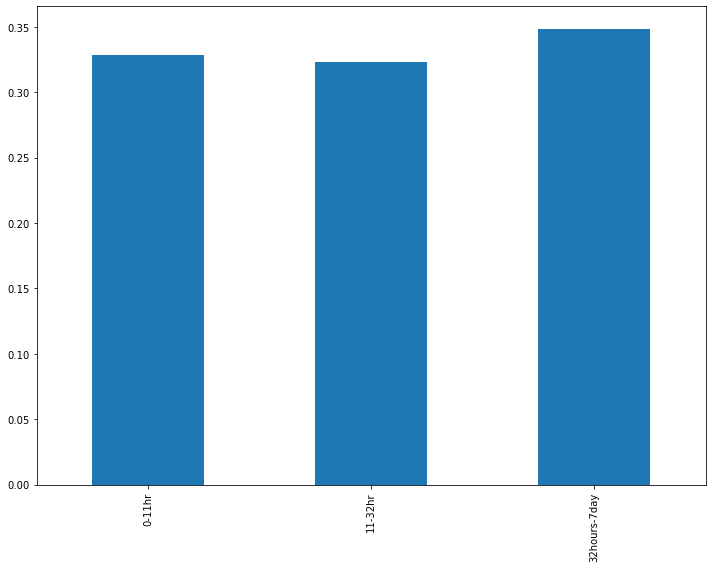

In [112]:
fig, ax = plt.subplots(figsize=(10, 8))

df['time_bin'].value_counts(normalize=True).sort_index().plot(kind='bar')

plt.tight_layout()

# Number Subjects

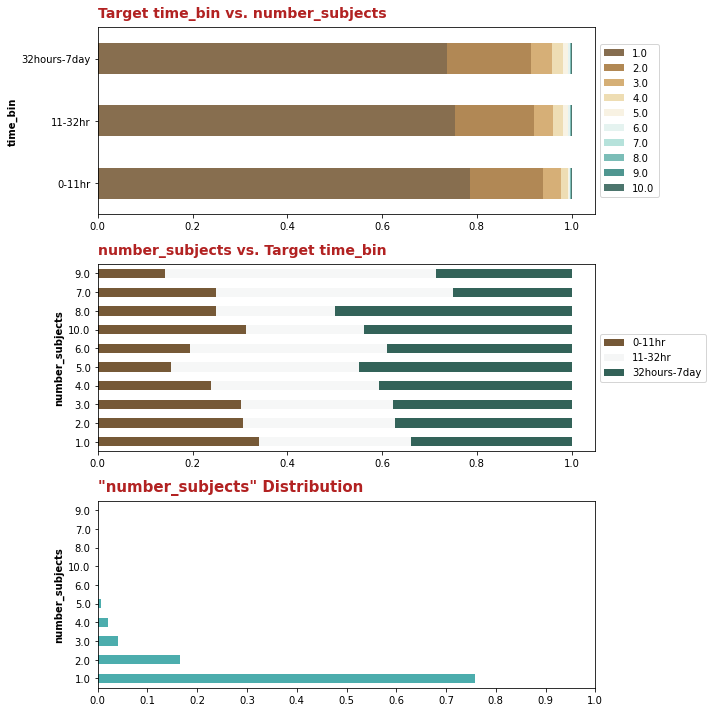

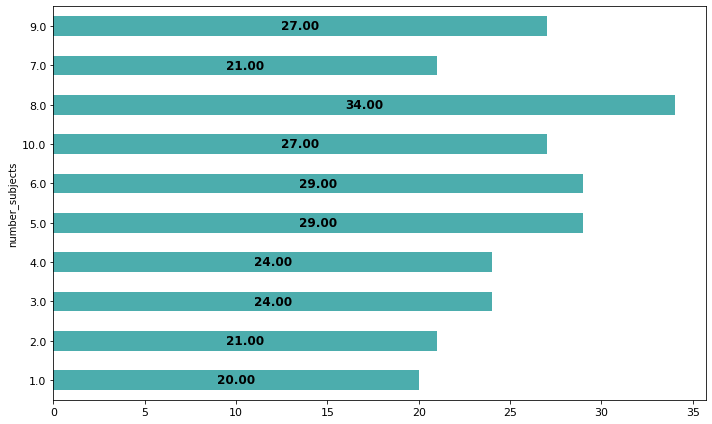

In [113]:
prop_dist_graph_2('number_subjects')

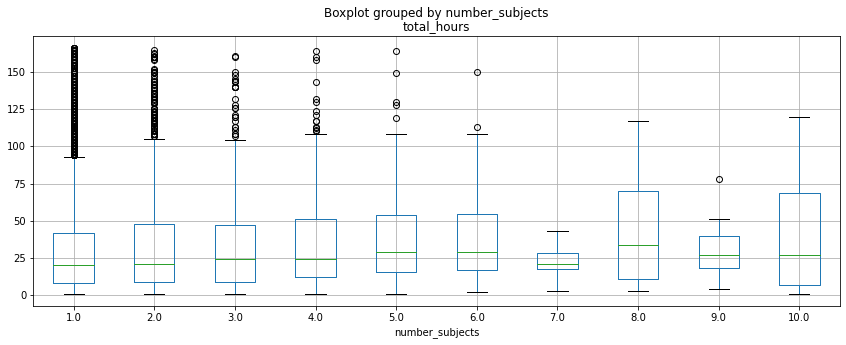

In [114]:
df.boxplot(column=['total_hours'], by='number_subjects', figsize=(14,5));

In [115]:
df.number_subjects.value_counts()

1.0     8267
2.0     1807
3.0      441
4.0      226
5.0       78
6.0       36
10.0      16
8.0       12
7.0        8
9.0        7
Name: number_subjects, dtype: int64

### Number Subjects
Observations
- Incidents with only one subject are the most fequent category. Contrary to what I expected, incidents with only one victim actually have the lowest median total_hours. 
- Coincidentally as the number of subjects increase, so does the time it takes to get rescued. This is contrary to what I would expect. It would make sense that the more subjects involved, the easier it would be for SAR teams to locate them. 
- When analyzing this feature against the target (time_bin), there does not seem to be a significant difference for each category. 
- I am going to include this feature in my models, though I don't expect it to be as indicative as the other included features.  

# Total Aircrafts

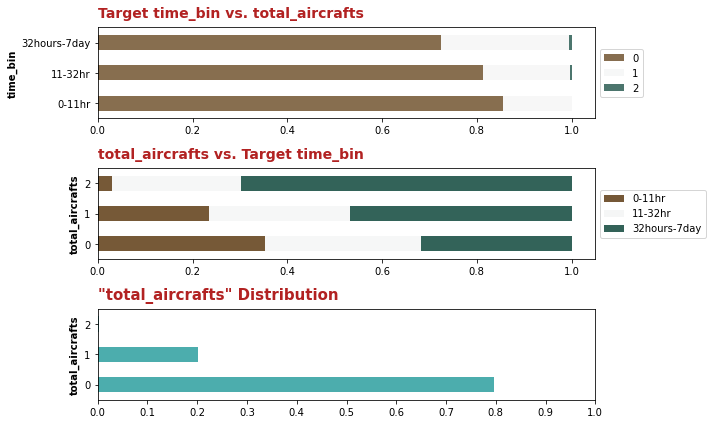

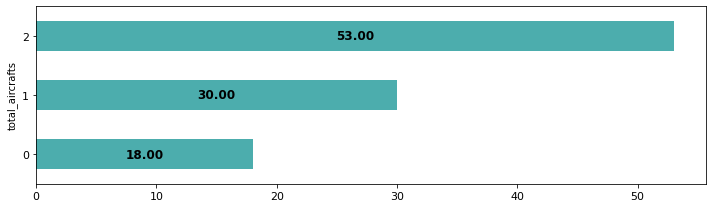

In [116]:
prop_dist_graph_2('total_aircrafts', 6, 3)

In [117]:
df.total_aircrafts.value_counts()

0    8677
1    2188
2      33
Name: total_aircrafts, dtype: int64

### Total Aircrafts
Observations
- This feature is a count of the total number of different types of aircrafts used in the SAR mission. 
    - helicopter, fixed-wing, UAV
- It makes sense that the more aircrafts used, the longer the SAR mission. Helicopters may be dispatched at the onset of a SAR mission if a rescue involving a hoist is recognized. If not, aircrafts may be called out later on in the SAR mission to aid in the search efforts. 
- 20% of the dataset include 1 type of aircraft, and only 33 datapoints include 2 types of aircrafts. The later but not be as useful in our models as a dummy variable, but we will include it and let lasso decide the usefulness of the feature. 

# Area Type

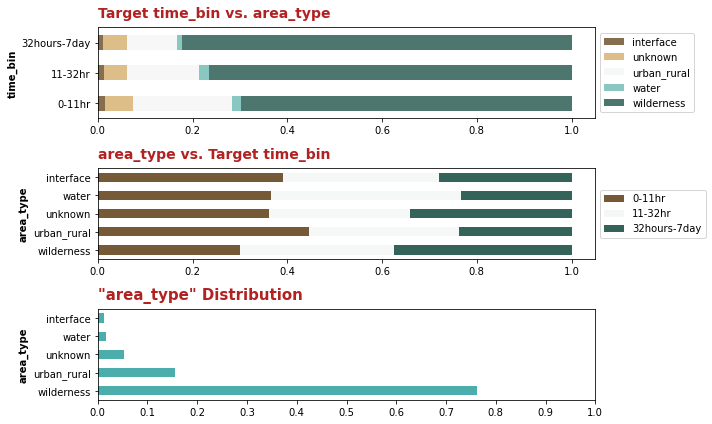

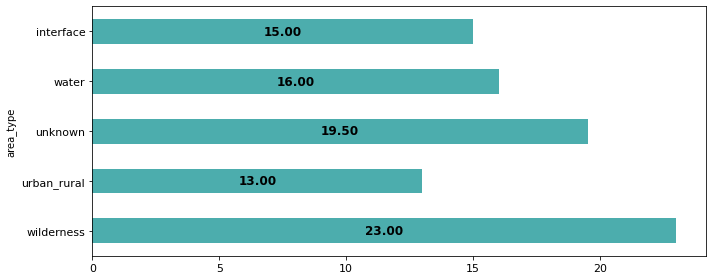

In [118]:
prop_dist_graph_2('area_type', 6, 4)

In [119]:
df.area_type.value_counts()

wilderness     8313
urban_rural    1695
unknown         572
water           175
interface       143
Name: area_type, dtype: int64

### Area Type
Observations
- 76% of the datapoints are in the wilderness. Understandably, these incidents have the highest average total_hours. 
- urban and rural incidents have the lowest median total_hours. 
- This feature will be dummied in the preprocessing notebook and included in my models. 

# Winter

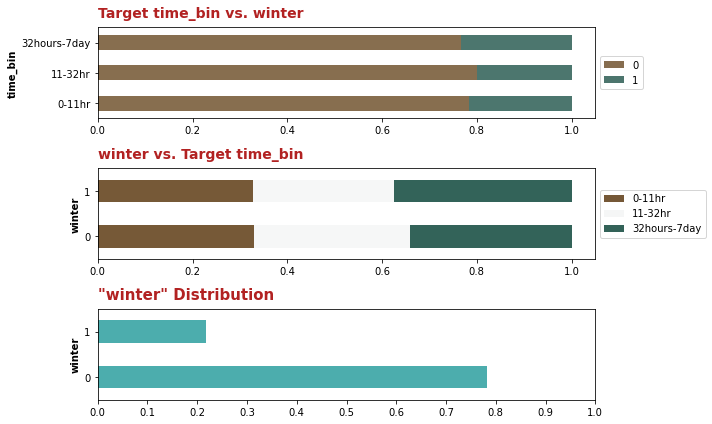

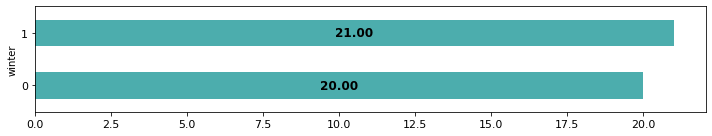

In [120]:
prop_dist_graph_2('winter', 6, 2)

### Winter
Observations
- This feature describes incidents that occured in winter or in snow. 
- There appears to be no difference in median or average time between the two categories. I will most likely not include this feature in my models. 

# Mental

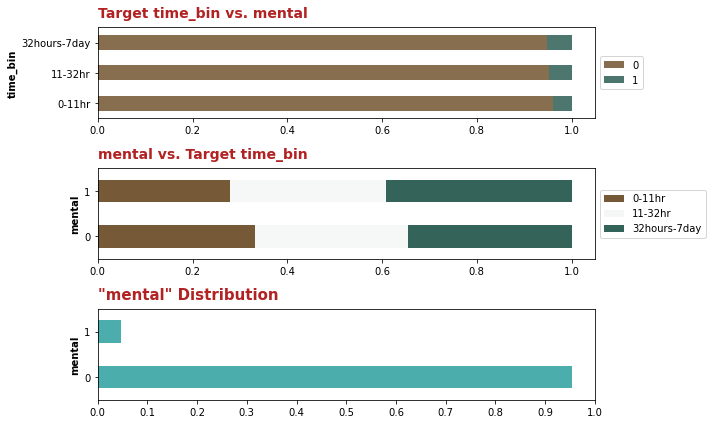

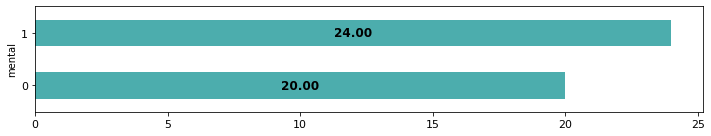

In [121]:
prop_dist_graph_2('mental', 6, 2)

### Mental 
Observations
- This is a OHE feature that is True if any subject as any mental condition or rating. 
- There is a slight increase in the average time it takes to complete a SAR mission when there is a mental factor present in any of the victims. 
- This feature will be included in my models

# Seniors

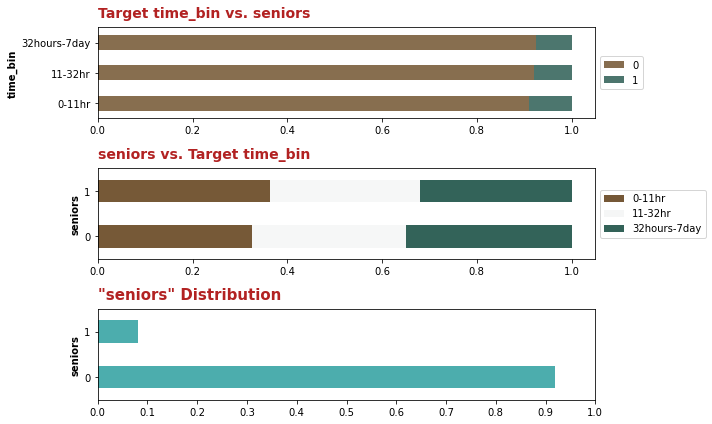

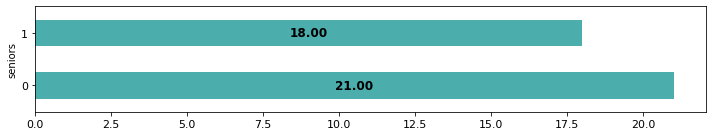

In [122]:
prop_dist_graph_2('seniors', 6, 2)

### Seniors
Observations
- This is a OHE feature that is True if any of the subjects are 65 or older. 
- Less than 1% of the dataset include seniors.
- Contrary to what I expected, incidents with seniors get rescued faster.
- I will include this feature in my models. 

# Children

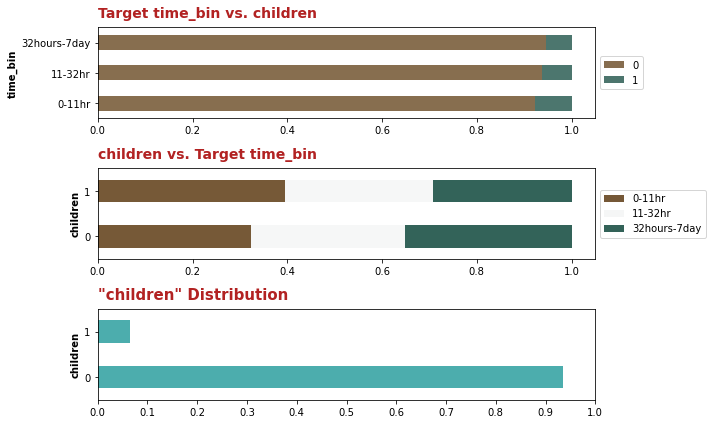

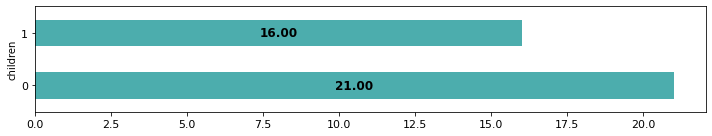

In [123]:
prop_dist_graph_2('children', 6, 2)

### Children 
Observations
- If any children 15 or younger are involved in an incident, this feature is True. 
- Less than 1% if the dataset include children, but those that do have considerably lower total hours. 
- I will include this feature in my models. 

# State

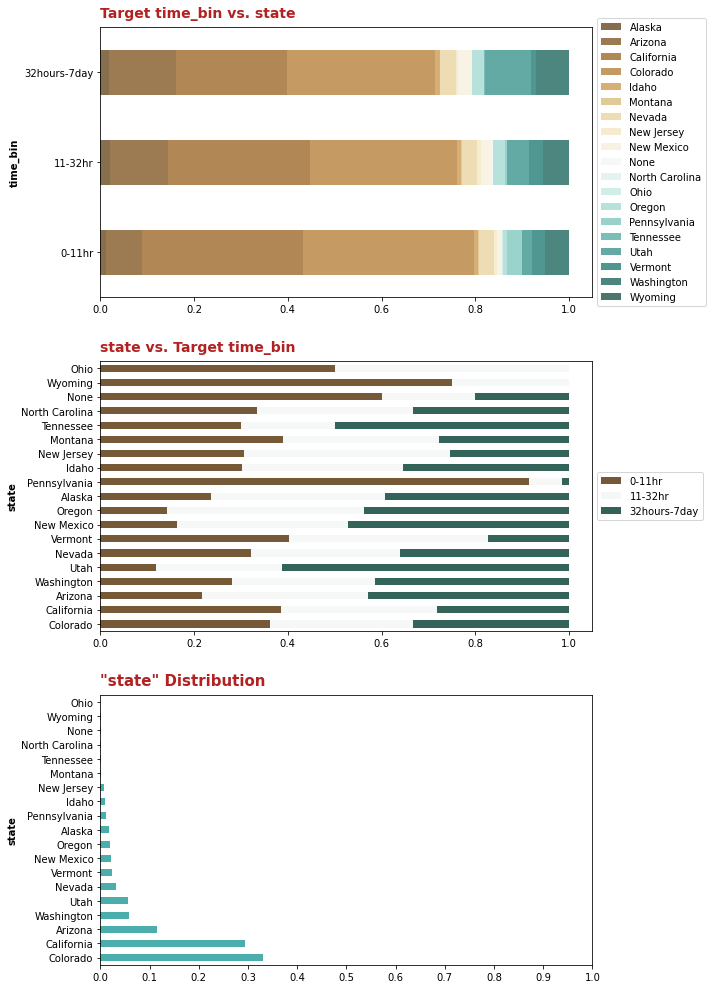

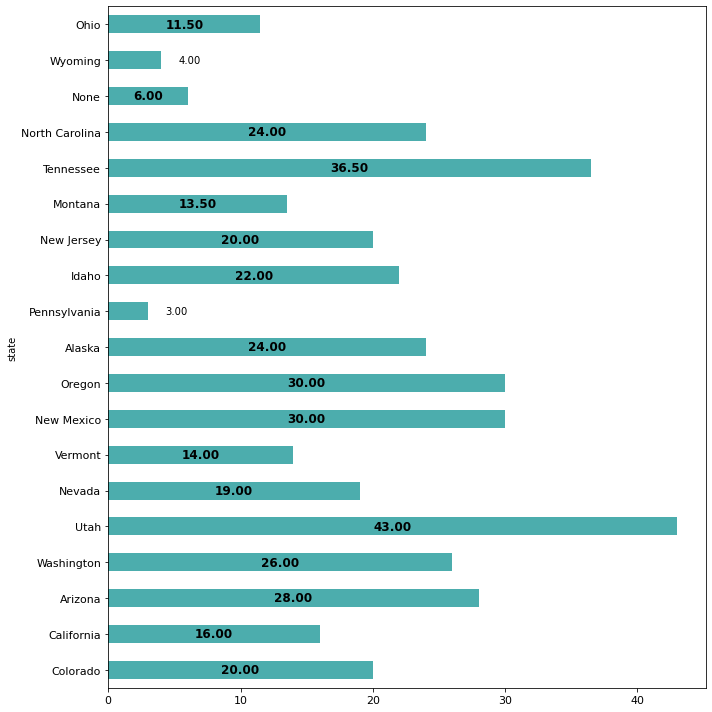

In [124]:
prop_dist_graph_2('state', 14, 10)

### State
- I included State as a feature instead of Team which had over 80 unique teams. 
- There are significant differences in average total_hours between all the different states. 
- California and Colorado consist of over 60% of the entire dataset, and both have pretty low average total_hours. 
    - These states most likely have highly experienced SAR teams 
- I will dummify this feature and include them in my models. 

# Number Volunteers

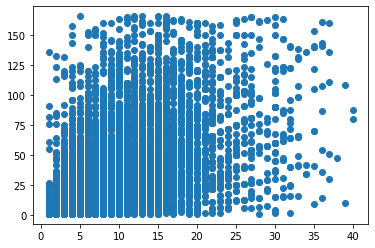

In [125]:
plt.scatter(x='number_volunteers', y='total_hours', data=df);

In [126]:
df.total_hours.corr(df.number_volunteers)

0.5180464683775706

### Number Volunteers
Observations 
- I expected this feature to have a higher correlation with the target variable total_hours. 
- Since it is the only actual continuous variable in the dataset, I will include it in my models, though lasso may not keep the feature. 

# Exporting Cleaned Dataframe

In [127]:
df.to_csv('../Data/cleaned_data.csv', index=False)